# 📊 EDA לתחזית נציגים

## טעינת ספריות בסיס

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from itertools import product
from IPython.display import clear_output
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit

## קריאת קבצי CSV

In [ ]:
cc_df = pd.read_csv("CC_2020-2025_New.csv")
holidays_df = pd.read_csv("Holidays.csv")

##  סקירה ראשונית

In [ ]:
print("--- CC Data Info ---")
cc_df.info()
print("\n--- Holidays Data Info ---")
holidays_df.info()

--- CC Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33601 entries, 0 to 33600
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   QueueStartDate        33601 non-null  object
 1   QueueStartDateNumber  33601 non-null  int64 
 2   QueueStartDateName    33601 non-null  object
 3   HourInterval          33601 non-null  object
 4   HalfHourInterval      33601 non-null  object
 5   TotalCallsOffered     33601 non-null  int64 
 6   TotalCallsAnswered    33601 non-null  int64 
 7   TotalCallsAbandoned   33601 non-null  int64 
 8   TotalCB               33601 non-null  int64 
 9   TotalTransfered       33601 non-null  int64 
 10  TotalWaitDuration     33601 non-null  int64 
 11  TotalAgents           33601 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 3.1+ MB

--- Holidays Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1327 entries, 0 to 1326
Data columns (tota

## שינוי שמות עמודות (לשמות באנגלית אחידים)


In [ ]:
cc_df.columns = [col.strip().replace(" ", "_").replace("-", "_") for col in cc_df.columns]
holidays_df.columns = [col.strip().replace(" ", "_").replace("-", "_") for col in holidays_df.columns]

## המרת עמודת תאריך לפורמט datetime

In [ ]:
cc_df['QueueStartDate'] = pd.to_datetime(cc_df['QueueStartDate'], dayfirst=True, errors='coerce')
holidays_df['CalendarDate'] = pd.to_datetime(holidays_df['CalendarDate'], dayfirst=True, errors='coerce')

## יצירת עמודות חדשות

In [ ]:
cc_df['Weekday'] = cc_df['QueueStartDate'].dt.day_name()
cc_df['IsWeekend'] = cc_df['Weekday'].isin(['Friday', 'Saturday'])
cc_df['AnsweredRatio'] = (cc_df['TotalCallsAnswered'] / cc_df['TotalAgents'])
cc_df['AnsweredRatio'] = cc_df['AnsweredRatio'].replace([np.inf, -np.inf], np.nan).fillna(0).round().astype(int)

## מיזוג מול טבלת חגים

In [ ]:
cc_df = cc_df.merge(holidays_df[['CalendarDate', 'HolidayNameHebrew']], left_on='QueueStartDate', right_on='CalendarDate', how='left')
cc_df['IsHoliday'] = cc_df['HolidayNameHebrew'].notna()
cc_df.drop(columns=['CalendarDate', 'HolidayNameHebrew'], inplace=True)

##  טיפול בערכים חסרים


In [ ]:
print("\nMissing values per column:")
print(cc_df.isna().sum())



Missing values per column:
QueueStartDate          0
QueueStartDateNumber    0
QueueStartDateName      0
HourInterval            0
HalfHourInterval        0
TotalCallsOffered       0
TotalCallsAnswered      0
TotalCallsAbandoned     0
TotalCB                 0
TotalTransfered         0
TotalWaitDuration       0
TotalAgents             0
Weekday                 0
IsWeekend               0
AnsweredRatio           0
IsHoliday               0
dtype: int64


## הסרת כפילויות


In [ ]:
original_len = len(cc_df)
cc_df.drop_duplicates(subset=['QueueStartDate', 'HalfHourInterval'], inplace=True)
print(f"🧹 נמחקו {original_len - len(cc_df)} כפילויות לפי QueueStartDate ו-HalfHourInterval")

🧹 נמחקו 0 כפילויות לפי QueueStartDate ו-HalfHourInterval


## תיאור סטטיסטי בסיסי

In [ ]:
print("\nDescriptive stats:")
print(cc_df.describe())


Descriptive stats:
                      QueueStartDate  QueueStartDateNumber  TotalCallsOffered  \
count                          33601          33601.000000       33601.000000   
mean   2022-09-24 19:43:45.886134016              3.258236         426.069700   
min              2020-01-01 00:00:00              1.000000           1.000000   
25%              2021-05-23 00:00:00              2.000000         171.000000   
50%              2022-09-21 00:00:00              3.000000         442.000000   
75%              2024-02-04 00:00:00              5.000000         632.000000   
max              2025-05-30 00:00:00              7.000000        1684.000000   
std                              NaN              1.597899         299.117702   

       TotalCallsAnswered  TotalCallsAbandoned       TotalCB  TotalTransfered  \
count        33601.000000         33601.000000  33601.000000     33601.000000   
mean           266.745365           100.105324     57.484599         1.578495   
min    

## גרפים בסיסיים

In [ ]:
fig1 = px.histogram(cc_df, x='Weekday', category_orders={'Weekday': ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']}, title='<b>מספר רשומות לפי יום בשבוע</b>')
fig1.update_layout(title={'x':0.5})
fig1.show()

fig2 = px.box(cc_df, x='HourInterval', y='TotalAgents', title='<b>התפלגות מספר נציגים לפי אינטרוול שעתי</b>')
fig2.update_layout(title={'x':0.5})
fig2.show()

fig3 = px.box(cc_df, x='HalfHourInterval', y='TotalAgents', title='<b>התפלגות מספר נציגים לפי אינטרוול חצאי שעות</b>')
fig3.update_layout(title={'x':0.5})
fig3.show()

# בחירת מודל אופטימלי לחיזוי

## המרת אינטרוול לפורמט מספרי: '10:00 - 10:30' -> 10.5


In [ ]:
def parse_interval(interval_str):
    start_time = interval_str.split(" - ")[0]
    hour, minute = map(int, start_time.split(":"))
    return hour + (0.5 if minute == 30 else 0.0)

In [ ]:
cc_df['Interval'] = cc_df['HalfHourInterval'].apply(parse_interval)

In [ ]:
cc_df['HalfHourInterval'].unique()

array(['07:30 - 08:00', '08:00 - 08:30', '08:30 - 09:00', '09:00 - 09:30',
       '09:30 - 10:00', '10:00 - 10:30', '10:30 - 11:00', '11:00 - 11:30',
       '11:30 - 12:00', '12:00 - 12:30', '12:30 - 13:00', '13:00 - 13:30',
       '13:30 - 14:00', '14:00 - 14:30', '14:30 - 15:00', '15:00 - 15:30',
       '15:30 - 16:00', '16:00 - 16:30', '16:30 - 17:00', '17:00 - 17:30',
       '17:30 - 18:00', '18:00 - 18:30', '18:30 - 19:00', '07:00 - 07:30',
       '19:00 - 19:30', '06:30 - 07:00', '22:30 - 23:00', '23:00 - 23:30',
       '20:00 - 20:30', '20:30 - 21:00', '21:00 - 21:30', '21:30 - 22:00',
       '22:00 - 22:30', '19:30 - 20:00', '23:30 - 00:00', '00:30 - 01:00',
       '01:00 - 01:30', '00:00 - 00:30', '04:30 - 05:00', '06:00 - 06:30',
       '05:30 - 06:00', '05:00 - 05:30'], dtype=object)

In [ ]:
cc_df['Interval'].unique()

array([ 7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
       13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. ,
       18.5,  7. , 19. ,  6.5, 22.5, 23. , 20. , 20.5, 21. , 21.5, 22. ,
       19.5, 23.5,  0.5,  1. ,  0. ,  4.5,  6. ,  5.5,  5. ])

In [ ]:
answer_ratio_lookup = cc_df.groupby(['Weekday', 'Interval', 'IsHoliday'])['AnsweredRatio'].mean().reset_index()
answer_ratio_lookup.to_csv("/content/answer_ratio_lookup.csv", index=False)
answer_ratio_lookup[
        (answer_ratio_lookup['Weekday'] == 'Monday') &
        (answer_ratio_lookup['Interval'] == 10.5) &
        (answer_ratio_lookup['IsHoliday'] == False)
    ]

,Weekday,Interval,IsHoliday,AnsweredRatio
48,Monday,10.5,False,5.334711


## בחירת משתנים לחיזוי


In [ ]:
features_full = ['Weekday', 'Interval', 'IsHoliday', 'AnsweredRatio']
target = 'TotalAgents'
X = cc_df[features_full]
y = cc_df[target]

## קידוד וטרנספורמציה

In [ ]:
# הגדרת cross-validation עם סדר כרונולוגי
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), ['Weekday']),
    ("num", 'passthrough', ['Interval', 'IsHoliday', 'AnsweredRatio'])
])

##  חלוקה ל-Train/Validation/Test

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


## יצירת מודלים להשוואה

In [ ]:
models = {
    'Linear Regression': Pipeline([
        ("prep", preprocessor),
        ("model", LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ("prep", preprocessor),
        ("model", RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ("prep", preprocessor),
        ("model", XGBRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ("prep", preprocessor),
        ("model", GradientBoostingRegressor(random_state=42))
    ])
}


## אימון וביצועים

In [ ]:
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'R2': r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("🔍 תוצאות המודלים הקלאסיים:")
print(results_df.to_string(index=False))

🔍 תוצאות המודלים הקלאסיים:
            Model       MAE      RMSE       R2
          XGBoost  9.598000 13.818962 0.810421
Gradient Boosting  9.919208 13.867302 0.809092
    Random Forest  9.692901 14.033353 0.804493
Linear Regression 19.648753 25.602953 0.349241


## מודל Neural Network (Keras)

In [ ]:
X_transformed = preprocessor.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)
X_train_nn, X_temp_nn, y_train_nn, y_temp_nn = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(X_temp_nn, y_temp_nn, test_size=0.25, random_state=42)
tf.keras.utils.set_random_seed(1)
model_nn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
# model_nn = Sequential([
#     Dense(256, activation='relu', input_shape=(X_train_nn.shape[1],)),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(1)
# ])
model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_nn.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=100, batch_size=64, verbose=0, callbacks=[early_stop])

loss, mae = model_nn.evaluate(X_test_nn, y_test_nn, verbose=1)
preds_nn = model_nn.predict(X_test_nn).flatten()
print("\nNeural Network")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_nn, preds_nn)):.2f}")
print(f"R2: {r2_score(y_test_nn, preds_nn):.2f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 171.4962 - mae: 9.4256
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Neural Network
MAE: 9.60
RMSE: 13.59
R2: 0.83


In [ ]:
def plot_loss(history, from_epoch=0, to_epoch=-1):
  plt.plot(history.history['loss'][from_epoch:to_epoch], label='loss')
  plt.plot(history.history['val_loss'][from_epoch:to_epoch], label='val_loss')
#   plt.ylim([0, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

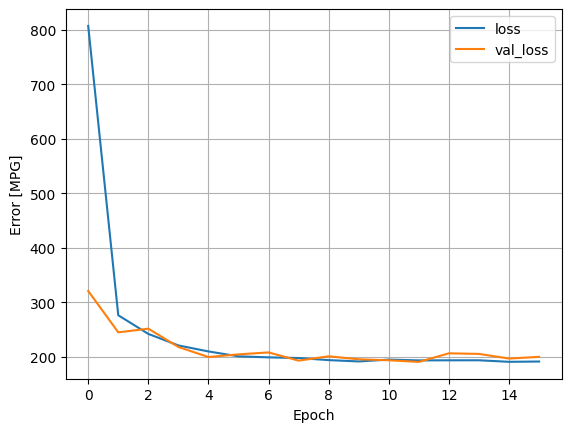

In [ ]:
plot_loss(history)

In [ ]:
results_df = pd.concat([results_df, pd.DataFrame([{
    'Model': 'Neural Network',
    'MAE': mae,
    'RMSE': np.sqrt(mean_squared_error(y_test_nn, preds_nn)),
    'R2': r2_score(y_test_nn, preds_nn)
}])], ignore_index=True)

## SARIMA Model


In [ ]:
def evaluate_sarima(df, order=(1,1,1), seasonal_order=(1,1,1,7)):
    tscv = TimeSeriesSplit(n_splits=5)
    errors = []

    df = df.copy()
    df = df.set_index('QueueStartDate').sort_index()
    series = df['TotalAgents'].resample('D').max().fillna(method='ffill')

    for train_index, test_index in tscv.split(series):
        train, test = series.iloc[train_index], series.iloc[test_index]
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            forecast = results.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, forecast))
            errors.append(rmse)
        except Exception as e:
            print(f"SARIMA Fold Error: {e}")
            continue

    return np.mean(errors)

In [ ]:
sarima_rmse = evaluate_sarima(cc_df[['QueueStartDate', 'TotalAgents']])

In [ ]:
print("\nSARIMA")
print(f"RMSE: {sarima_rmse:.2f}")


SARIMA
RMSE: 18.47


In [ ]:
results_df = pd.concat([results_df, pd.DataFrame([{
    'Model': 'SARIMA',
    'MAE': np.nan,
    'RMSE': sarima_rmse,
    'R2': np.nan
}])], ignore_index=True)

## Prophen Model

In [ ]:
def evaluate_prophet(df):
    df_prophet = df[['QueueStartDate', 'TotalAgents']].rename(columns={'QueueStartDate': 'ds', 'TotalAgents': 'y'})
    df_prophet = df_prophet.sort_values('ds')
    tscv = TimeSeriesSplit(n_splits=5)
    errors = []
    for train_index, test_index in tscv.split(df_prophet):
        train, test = df_prophet.iloc[train_index], df_prophet.iloc[test_index]
        model = Prophet()
        model.fit(train)
        future = test[['ds']]
        forecast = model.predict(future)
        rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
        errors.append(rmse)
    return np.mean(errors)

In [ ]:
prophet_rmse = evaluate_prophet(cc_df[['QueueStartDate', 'TotalAgents']])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjchs3hex/od277wub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjchs3hex/0k3iyeba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15175', 'data', 'file=/tmp/tmpjchs3hex/od277wub.json', 'init=/tmp/tmpjchs3hex/0k3iyeba.json', 'output', 'file=/tmp/tmpjchs3hex/prophet_modelcn0zym2d/prophet_model-20250703063957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:39:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

In [ ]:
results_df = pd.concat([results_df, pd.DataFrame([{
    'Model': 'Prophet',
    'MAE': np.nan,
    'RMSE': prophet_rmse,
    'R2': np.nan
}])], ignore_index=True)

## השוואה בין כל המודלים

In [ ]:
# הוספת התוצאה לטבלת הסיכום
results_df = pd.concat([
    results_df
], ignore_index=True).sort_values(by='RMSE')

print("🔍 טבלת ביצועים מעודכנת:")
print(results_df.to_string(index=False))

best_model_row = results_df.sort_values(by='RMSE').iloc[0]
print(f"\n✅ המודל האופטימלי לפי RMSE הוא: {best_model_row['Model']}")

🔍 טבלת ביצועים מעודכנת:
            Model       MAE      RMSE       R2
   Neural Network  9.704268 13.665469 0.824893
          XGBoost  9.598000 13.818962 0.810421
Gradient Boosting  9.919208 13.867302 0.809092
    Random Forest  9.692901 14.033353 0.804493
           SARIMA       NaN 18.465870      NaN
Linear Regression 19.648753 25.602953 0.349241
          Prophet       NaN 31.345330      NaN

✅ המודל האופטימלי לפי RMSE הוא: Neural Network


### גרף השוואה של ביצועי המודלים

In [ ]:
fig_perf = px.bar(results_df, x='Model', y='RMSE', text='RMSE', title='<b>השוואת RMSE בין המודלים</b>')
fig_perf.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_perf.update_layout(title={'x': 0.5}, yaxis_title='RMSE', xaxis_title='Model')
fig_perf.show()


## שמירת המודל הטוב ביותר


In [ ]:
import os
import glob
model_files = glob.glob('/content/*.pkl') + glob.glob('/content/*.keras') + glob.glob('/content/*.h5')
for f in model_files:
    try:
        os.remove(f)
        print(f"🗑️ נמחק: {f}")
    except Exception as e:
        print(f"⚠️ שגיאה במחיקת {f}: {e}")

🗑️ נמחק: /content/scaler.pkl
🗑️ נמחק: /content/preprocessor.pkl
🗑️ נמחק: /content/neural_network.keras


In [ ]:
best_model_row = results_df.sort_values(by='RMSE').iloc[0]
best_model_name = best_model_row['Model']
print(f"\n✅ המודל האופטימלי לפי RMSE הוא: {best_model_name}")

if best_model_name == 'Neural Network':
    model_filename = "/content/neural_network.keras"
    model_nn.save(model_filename)
    joblib.dump(preprocessor, "/content/preprocessor.pkl")
    joblib.dump(scaler, "/content/scaler.pkl")

elif best_model_name in models:
    model_filename = f"/content/{best_model_name.replace(' ', '_').lower()}.pkl"
    model_with_preprocessing = Pipeline([("prep", preprocessor), ("model", models[best_model_name].named_steps['model'])])
    joblib.dump(model_with_preprocessing, model_filename)

elif best_model_name == 'Prophet':
    prophet_df = cc_df[['QueueStartDate', 'TotalAgents']].rename(columns={
        'QueueStartDate': 'ds',
        'TotalAgents': 'y'
    })
    model = Prophet()
    model.fit(prophet_df)
    model_filename = "/content/prophet_model.pkl"
    joblib.dump(model, model_filename)

elif best_model_name == 'SARIMA':
    series = cc_df.set_index('QueueStartDate')['TotalAgents'].asfreq('D').fillna(method='ffill')
    model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
    model_filename = "/content/sarima_model.pkl"
    joblib.dump(model, model_filename)

print(f"\n📦 המודל הטוב ביותר נשמר בשם: {model_filename}")


✅ המודל האופטימלי לפי RMSE הוא: Neural Network

📦 המודל הטוב ביותר נשמר בשם: /content/neural_network.keras


# טעינת המודל מהקובץ

In [ ]:
import pathlib
Path = pathlib.Path

def load_model(path):
    if Path(path).exists():
        if path.endswith('.keras'):
            return tf.keras.models.load_model(path)
        elif path.endswith('.pkl'):
            return joblib.load(path)
        else:
            print("⚠️ סיומת לא נתמכת לקובץ המודל.")
            return None
    else:
        print("⚠️ קובץ המודל לא נמצא.")
        return None

# פונקציה לאימון מחדש על דאטה חדש


In [ ]:
def retrain_model(model_name, X_new, y_new):
    if model_name == 'Neural Network':
        pre = joblib.load("/content/preprocessor.pkl")
        scaler_loaded = joblib.load("/content/scaler.pkl")
        X_transformed = pre.transform(X_new)
        X_scaled = scaler_loaded.transform(X_transformed)
        model = tf.keras.models.load_model("/content/neural_network.keras")
        model.fit(X_scaled, y_new, epochs=30, batch_size=32, verbose=0)
        model.save("/content/neural_network_retrained.keras")
        return model
    elif model_name in models:
        pipe = models.get(model_name)
        pipe.fit(X_new, y_new)
        joblib.dump(pipe, f"/content/{model_name.replace(' ', '_').lower()}_retrained.pkl")
        return pipe
    elif model_name == 'Prophet':
        model = Prophet()
        df = pd.concat([X_new, y_new], axis=1).rename(columns={'QueueStartDate': 'ds', 'TotalAgents': 'y'})
        model.fit(df)
        joblib.dump(model, "data/prophet_model_retrained.pkl")
        return model
    elif model_name == 'SARIMA':
        series = pd.concat([X_new, y_new], axis=1).set_index('QueueStartDate')['TotalAgents'].asfreq('D').fillna(method='ffill')
        model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
        joblib.dump(model, "/content/sarima_model_retrained.pkl")
        return model
    else:
        print(f"⚠️ מודל {model_name} לא נתמך.")
        return None

# פונקציית חיזוי לפי קלט חדש

In [ ]:
def predict_total_agents(model_path, weekday: str, interval, is_holiday: bool):
    if is_holiday:
        print("🔕 יום חג – חוזר 0")
        return 0

    # המרה אם interval הוא מ- HalfHourInterval
    if isinstance(interval, str) and ':' in interval:
        hour, minute = map(int, interval.split(' - ')[0].split(':'))
        interval = hour + (0.5 if minute == 30 else 0.0)

    model = load_model(model_path)
    if model is None:
        return None

    ratio_row = answer_ratio_lookup[
        (answer_ratio_lookup['Weekday'] == weekday) &
        (answer_ratio_lookup['Interval'] == interval) &
        (answer_ratio_lookup['IsHoliday'] == is_holiday)
    ]

    if ratio_row.empty:
        print("⚠️ לא נמצא AnsweredRatio מתאים, משתמש ב-0.8")
        answered_ratio = 0.8
    else:
        answered_ratio = ratio_row['AnsweredRatio'].values[0]

    input_df = pd.DataFrame([{
        'Weekday': weekday,
        'Interval': interval,
        'IsHoliday': is_holiday,
        'AnsweredRatio': answered_ratio
    }])

    if model_path.endswith('.keras'):
        pre = joblib.load("/content/preprocessor.pkl")
        scaler_loaded = joblib.load("/content/scaler.pkl")
        X_transformed = pre.transform(input_df)
        X_scaled = scaler_loaded.transform(X_transformed)
        prediction = model.predict(X_scaled)
    else:
        prediction = model.predict(input_df)

    prediction = max(0, float(prediction[0]))
    print(f"🔮 תחזית נציגים: {int(round(prediction))} (Interval: {interval})")
    return int(round(float(prediction)))

In [ ]:
# 🧪 דוגמה לשימוש בפונקציית חיזוי
predict_total_agents(model_filename, weekday='Monday', interval=10.5, is_holiday=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
🔮 תחזית נציגים: 79 (Interval: 10.5)


79

# ממשק אינטראקטיבי לחיזוי


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

weekday_widget = widgets.Dropdown(
    options=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
    description='Weekday:',
    value='Monday'
)
interval_widget = widgets.FloatSlider(
    value=10.5, min=0, max=23.5, step=0.5,
    description='Interval:'
)
holiday_widget = widgets.Checkbox(
    value=False,
    description='Holiday?'
)
run_button = widgets.Button(description="🔮 חזה")
output_box = widgets.Output()

model_paths = {
    'Neural Network': '/content/neural_network.keras',
    'Random Forest': '/content/random_forest.pkl',
    'Gradient Boosting': '/content/gradient_boosting.pkl',
    'XGBoost': '/content/xgboost.pkl',
    'Linear Regression': '/content/linear_regression.pkl',
    'Prophet': '/content/prophet_model.pkl',
    'SARIMA': '/content/sarima_model.pkl',
}

selected_model_path = model_paths.get(best_model_name)

@output_box.capture()
def on_run_clicked(b):
    clear_output()
    predict_total_agents(
        model_path=selected_model_path,
        weekday=weekday_widget.value,
        interval=interval_widget.value,
        is_holiday=holiday_widget.value
    )

run_button.on_click(on_run_clicked)

print("\n📋 ממשק חיזוי אינטראקטיבי:")
display(weekday_widget, interval_widget, holiday_widget, run_button, output_box)



📋 ממשק חיזוי אינטראקטיבי:


Dropdown(description='Weekday:', index=1, options=('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Fr…

FloatSlider(value=10.5, description='Interval:', max=23.5, step=0.5)

Checkbox(value=False, description='Holiday?')

Button(description='🔮 חזה', style=ButtonStyle())

Output()

# ממשק Gradio לחיזוי


In [ ]:
import gradio as gr
from gradio.themes.base import Base

class CustomTheme(Base):
    def __init__(self):
        super().__init__()
        self.primary_hue = "green"
        self.font = "Alef"
        self.button_primary_background = "#00796B"
        self.button_primary_text = "white"

def gradio_predict(weekday, interval, is_holiday):
    return predict_total_agents(model_filename, weekday, interval, is_holiday)

gr.Interface(
    fn=gradio_predict,
    inputs=[
        gr.Dropdown(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], label="יום בשבוע"),
        gr.Dropdown(
            choices=[(label, parse_interval(label)) for label in sorted(cc_df['HalfHourInterval'].unique().tolist())],
            label="אינטרוול (חצי שעה)"
        ),
        gr.Checkbox(label="האם זה חג?")
    ],
    outputs=gr.Number(label="תחזית נציגים", precision=0),
    title="🔮 חיזוי מספר נציגים",
    description="בחר יום בשבוע, אינטרוול והאם זה חג – לקבלת תחזית לפי המודל הטוב ביותר",
    theme=CustomTheme(),
    live=True
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7e3c40ef1a7a800ae.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
